## Manipulator Kinematics ##

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle
from IPython.display import display, clear_output
import numpy as np
import cv2
import copy
from numpy import cos, sin, pi, exp
from math import fabs, sqrt
import time
import random
import operator

In [2]:
import sys
sys.path.append("C:/Users/Mafeus/Desktop/Git_Repos/OpenCV")
import OpCV_Utils

In [3]:
import Utils_3D as Ut3D

End Effector Position: 369.5180086711132 57.522467597413225 211.36481776669305


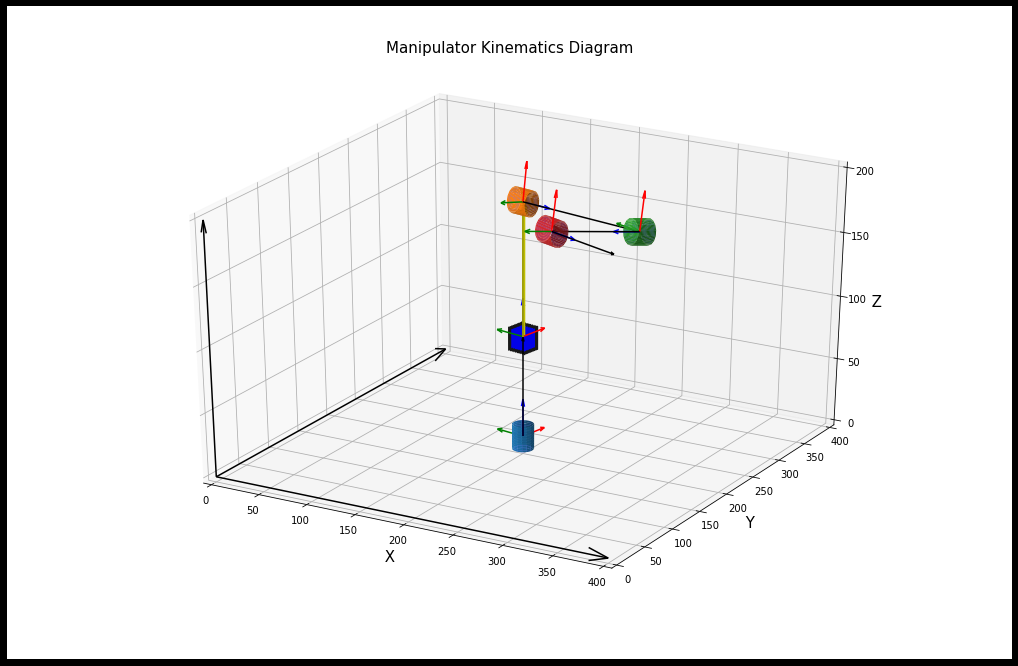

In [49]:
# Graph Properties:
fig = plt.figure(figsize=(18,12), facecolor='k')
ax = fig.add_subplot(111, projection='3d')

# Initial Positions:
theta1 = 0
theta2 = 0
theta4 = 0
theta5 = 0
L3 = 80; i = 1
f1 = 1
f2 = 1
f4 = 1
f5 = 1

while True:
        
    Xmin, Xmax = 0, 400
    Ymin, Ymax = 0, 400
    Zmin, Zmax = 0, 200

    ax.set_xlabel('\n X ', fontsize=15)
    ax.set_ylabel('\n Y ', fontsize=15)
    ax.set_zlabel('\n Z ', fontsize=15)

    ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    ax.set_zticks([0, 50, 100, 150, 200])
    ax.dist = 12

    ax.set_xlim([Xmin, Xmax])
    ax.set_ylim([Ymin, Ymax])
    ax.set_zlim([Zmin, Zmax])

    ax.set_title('Manipulator Kinematics Diagram', fontsize=15)

    ax.quiver(Xmin, 0, 0, Xmax, 0, 0, arrow_length_ratio = 0.05, color='k')
    ax.quiver(0, Ymin, 0, 0, Ymax, 0, arrow_length_ratio = 0.05, color='k')
    ax.quiver(0, 0, Zmin, 0, 0, Zmax, arrow_length_ratio = 0.05, color='k')
    
    #########################
    # Movement over time:
    
    # Revolute:
    theta1+=5*f1
    theta2+=5*f2
    theta4+=5*f4
    theta5+=5*f5
    
    if (theta1 >= 90):
        f1 = -1
    if (theta1 <= -90):
        i = 1
        
    if (theta2 >= 90):
        f2 = -1
    if (theta2 <= -90):
        f2 = 1
        
    if (theta4 >= 45):
        f4 = -1
    if (theta4 <= -45):
        f4 = 1
        
    if (theta5 >= 60):
        f5 = -1
    if (theta4 <= -60):
        f5 = 1

    # Prismatic:
    L3+=3*i
    if (L3 > 120):
        i = -1
    if (L3 < 80):
        i = 1
    ########################

    # Frame 1:
    F1_orientation = (0,0,0)
    F1_mov_angle   = theta1
    x, y, z        = 200, 200, 10
    F1_jointType   = 'Revolute Joint'
    Link1          = 80
    
    # Frame 2:
    Link2 = 130
    F2_orientation = (90,0,0)
    F2_mov_angle   = theta2
    F2_jointType   = 'Revolute Joint'
    
    # Frame 3:
    Link3 = L3
    F3_orientation = (0,0,0)
    F3_mov_angle   = 0
    F3_jointType   = 'Prismatic Joint'
    
    # Frame 4:
    Link4 = 100
    F4_orientation = (0,0,0)
    F4_mov_angle   = theta4
    F4_jointType   = 'Revolute Joint'
    
    # Frame 5:
    Link5 = 80
    F5_orientation = (90,0,0)
    F5_mov_angle   = theta5
    F5_jointType   = 'Revolute Joint'
    
    frameOne   = [x, y, z, F1_orientation, F1_mov_angle, F1_jointType, Link1]
    frameTwo   = [Link2, F2_orientation, F2_mov_angle, F2_jointType]
    frameThree = [Link3, F3_orientation, F3_mov_angle, F3_jointType]
    frameFour  = [Link4, F4_orientation, F4_mov_angle, F4_jointType]
    frameFive  = [Link5, F5_orientation, 0, F5_jointType]

    frame_list = [frameOne, frameTwo, frameThree, frameFour, frameFive]
    frame_list = [frameOne, frameThree, frameTwo, frameFour, frameFive]
    
    end_effector_x, end_effector_y, end_effector_z = kinDiagram(ax, frame_list)
    
    clear_output(wait=True)
    
    print("End Effector Position:", end_effector_x, end_effector_y, end_effector_z)
    
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    cv2.imshow("Grid", img)
    
    key = cv2.waitKey(1) or 0xff   
    if key == ord('k'):
        break

    ax.cla()
            
cv2.destroyAllWindows()

In [47]:
def drawLink(ax, x1, y1, z1, link_length, joint_type, orientation, movement_angle):
    
    LinkArray = linkDirection(orientation, link_length)
            
    RX, RY, RZ = movement_angle
    x2, y2, z2 = Ut3D.Rot(RX, RY, RZ).dot(LinkArray) + np.array([x1, y1, z1])
    
    origin = np.array([x1, y1, z1])
    vector = np.array([x2 - x1, y2 - y1, z2 - z1])
    
    X, Y, Z, U, V, W = Ut3D.vec_to_quiver(origin, vector)
    ax.quiver(X, Y, Z, U, V, W, arrow_length_ratio = 0.05, color='k')
    
    if (joint_type == 'Prismatic Joint'):
        ax.quiver(X, Y, Z, U, V, W, arrow_length_ratio = 0.1, color='y')
        ax.quiver(X+1, Y+1, Z+1, U, V, W, arrow_length_ratio = 0.1, color='y')
    
    return x2, y2, z2

In [6]:
def kinDiagram(ax, frame_list):
    
    ############################################################################################################
    # Frame One:
    
    frameOne = frame_list[0]
    
    orientation = frameOne[3]
    movement_angle = mov_dir(orientation, frameOne[4])
    
    x, y, z = frameOne[0], frameOne[1], frameOne[2]
    
    if frameOne[5] == 'Revolute Joint':
        
        radius = 10
        height = 20
        
        Ut3D.drawCylinder(ax, x, y, z, radius, height, orientation, movement_angle)
        Ut3D.drawFrameAxis(ax, x, y, z, orientation, movement_angle)
        
    elif frameOne[5] == 'Prismatic Joint':
        
        L = 20
        
        Ut3D.drawCube(ax, x, y, z, L, movement_angle)
        Ut3D.drawFrameAxis(ax, x, y, z, orientation, movement_angle)
        
    else:
        print('Wrong Joint Type Defined.')
        
    link_length = frameOne[6]
    x, y, z = drawLink(ax, x, y, z, link_length, frameOne[5], orientation, movement_angle)
        
    ############################################################################################################
    
    for n, frame in enumerate(frame_list):    

        previous_mov_angle = (movement_angle[0], movement_angle[1], movement_angle[2])
                
        if (n > 0):
                        
            orientation = frame[1]
            movement_angle = mov_dir(orientation, frame[2])
            movement_angle = tuple(map(operator.add, movement_angle, previous_mov_angle))
                                                                                                
            if frame[3] == 'Revolute Joint':
        
                radius = 10
                height = 20

                Ut3D.drawCylinder(ax, x, y, z, radius, height, orientation, movement_angle)
                Ut3D.drawFrameAxis(ax, x, y, z, orientation, movement_angle)
        
            elif frame[3] == 'Prismatic Joint':

                L = 20

                Ut3D.drawCube(ax, x, y, z, L, movement_angle)
                Ut3D.drawFrameAxis(ax, x, y, z, orientation, movement_angle)
                
            else:
                print('Wrong Joint Type Defined.')
                
            link_length = frame[0]
            x, y, z = drawLink(ax, x, y, z, link_length, frame[3], orientation, movement_angle)
            
    return x, y, z

In [7]:
def mov_dir(orientation, angle):
    
    if (orientation == (0,0,0)):
        mov_angle = (0,0,angle)
    
    elif (orientation == (90,0,0)):
        mov_angle = (0,-angle,0)
    
    elif (orientation == (-90,0,0)):
        mov_angle = (0,angle,0)
    
    elif (orientation == (0,90,0)):
        mov_angle = (angle,0,0)
    
    elif (orientation == (0,-90,0)):
        mov_angle = (-angle,0,0)
    
    elif (orientation == (0,0,90)):
        mov_angle = (0,0,angle)
    
    elif (orientation == (0,0,-90)):
        mov_angle = (0,0,angle)
    
    else:
        print("Wrong Orientation")
        mov_angle = None
    
    return mov_angle

In [8]:
def linkDirection(orientation, link_length):
    
    if (orientation == (0,0,0)):
        link_array = np.array([0,0,link_length])
    
    elif (orientation == (90,0,0)):
        link_array = np.array([0,-link_length, 0])
    
    elif (orientation == (-90,0,0)):
        link_array = np.array([0,link_length, 0])
    
    elif (orientation == (0,90,0)):
        link_array = np.array([link_length,0,0])
    
    elif (orientation == (0,-90,0)):
        link_array = np.array([-link_length,0,0])
    
    elif (orientation == (0,0,90)):
        link_array = np.array([0,0,link_length])
    
    elif (orientation == (0,0,-90)):
        link_array = np.array([0,0,link_length])
    
    else:
        print("Wrong Orientation")
        mov_angle = None
    
    return link_array